# Лабораторная работа №2. Ассоциативные правила

## 1. Введение

**Цель работы:** исследование методов анализа ассоциативных правил.

**Постановка задачи:**

1. Загрузить датасет из репозитория (например, kaggle.com или аналогичных платформ). Данные должны представлять собой информацию о купленных вместе товарах .

2. Привести описание данных из датасета: график вывода длин транзакций, список уникальных товаров и др. 

3. Алгоритм Apriori: выполнить анализ ассоциативных правил при помощи алгоритма Apriori с изначальными условиями в соответствии с вариантом задания. Проанализировать полученные результаты, выделив полезные и тривиальные правила, и оценив значение достоверности, лифта правил. Провести оценку влияния параметров алгоритма на получаемые правила (на количество правил и метрики).

4. Алгоритм FPG: провести анализ правил, используя алгоритм FPG. В отчете привести правила, получившиеся в результате использования данного алгоритма.

5. Алгоритмически определить минимальные значения поддержки для составления правил из 1, 2, и т.д. объектов в одном из алгоритмов.

6. Последовательно меняя параметры (значения поддержки и достоверности) одного из алгоритмов получить наборы ассоциативных правил. Сделать выводы на основе проведенных экспериментов.

7. Проанализировать получающийся в результате работы программы граф. Объяснить, какую информацию можно из него извлечь.

8. Предложить и реализовать свой способ визуализации ассоциативных правил и метрик.

## 2. Анализ данных 

       Cobra Kai          Lupin   12 Monkeys          Sherlock  \
0           Lost      Jack Ryan    The Flash   Game of thrones   
1  Sex Education      Dr. House      Kingdom  The Walking Dead   
2          Ozark  Sex Education  Constantine          Preacher   
3         Naruto            NaN          NaN               NaN   
4  Sex Education            NaN          NaN               NaN   

       Unnamed: 4  Unnamed: 5 Unnamed: 6 Unnamed: 7     Unnamed: 8  \
0  House of Cards  12 Monkeys    Vikings     Fringe  The Mentalist   
1             NaN         NaN        NaN        NaN            NaN   
2         Vikings    The Tick        NaN        NaN            NaN   
3             NaN         NaN        NaN        NaN            NaN   
4             NaN         NaN        NaN        NaN            NaN   

     Unnamed: 9  ... Unnamed: 22 Unnamed: 23 Unnamed: 24 Unnamed: 25  \
0  The Alienist  ...         NaN         NaN         NaN         NaN   
1           NaN  ...         NaN      

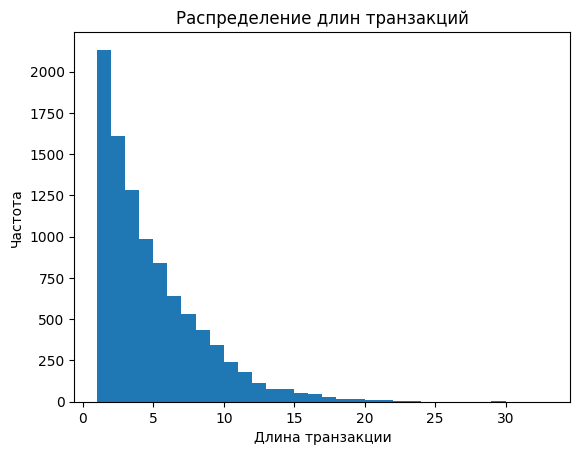

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
import networkx as nx
import numpy as np
import kagglehub
import os

path = kagglehub.dataset_download("cyberphile/ott-tvshows")
csv_path = os.path.join(path, "TV_Shows.csv")
all_data = pd.read_csv(csv_path)
print(all_data.head())

transaction_lengths = all_data.notnull().sum(axis=1)
plt.hist(transaction_lengths, bins=range(1, max(transaction_lengths) + 2))
plt.xlabel('Длина транзакции')
plt.ylabel('Частота')
plt.title('Распределение длин транзакций')
plt.show()

Формат данных:

Каждая строка = одна транзакция (выборка просмотренных/выбранных пользователем шоу).
В строке перечислены названия TV-шоу в разных столбцах (Cobra Kai, Lupin, 12 Monkeys, Sherlock, ..., Unnamed: 31).
Отсутствующие значения обозначены как NaN.
Количество столбцов — 32.

In [3]:
np_data = all_data.to_numpy()
np_data = [[elem for elem in row[1:] if isinstance(elem,str)] for row in np_data]

unique_items = set()
for row in np_data:
    for elem in row:
        unique_items.add(elem)
print(unique_items)
print(f"Всего уникальных TV-шоу: {len(unique_items)}")

te = TransactionEncoder()
te_ary = te.fit(np_data).transform(np_data)
data = pd.DataFrame(te_ary, columns=te.columns_)

{'12 Monkeys', 'Euphoria', "The Handmaid's Tale", 'True Detective', 'Rick And Morty', 'Watchmen', 'The Vampire Diaries', 'Travellers', 'The Originals', 'Fringe', 'Spartacus', 'Nine Perfect Strangers', 'Upload', 'Jack Ryan', 'Orphan Black', 'Naruto', 'Two and a half men', 'Peaky Blinders', 'The Boys', 'The 100', 'The Walking Dead', 'Sense 8', 'Sons of Anarchy', 'Dr Stone', 'Alice in Borderland', 'Big Little Lies', 'Kingdom', 'Dexter', 'Mr. Robot', 'Cobra Kai', 'Mirzapur', 'Atypical', 'Space Force', 'Rome', 'Sopranos', 'Young Sheldon', 'The Big Bang Theory', 'How to get away with murder', 'Hunters', 'Shooter', 'Narcos', 'Lupin', 'Banshee', 'Doctor Who', 'The Blacklist', 'Altered Carbon', 'Sex Education', 'Modern Family', 'Punisher', 'Outlander', 'Death Note', 'The Wheel of Time', 'How I met your mother', 'Emily in Paris', 'Bojack Horseman', 'Constantine', 'Archer', 'Invincible', 'South Park', 'Dark', 'Heros', 'Riverdale', 'Shadow and Bone', 'The Flash', 'Locke & Key', 'Sacred Games', 'Su

## 3. Ход работы

### Алгоритм Apriori

Начальные параметры для обоих алгоритмов: поддержка 0.02 и достоверность 0.3. 

     support                               itemsets
0   0.055940                           (12 Monkeys)
1   0.045928                             (Absentia)
2   0.023222                  (Alice in Borderland)
3   0.049644                               (Archer)
4   0.117143                             (Atypical)
..       ...                                    ...
77  0.025183         (Sex Education, The Blacklist)
78  0.022913         (Sex Education, The Mentalist)
79  0.026938      (Sex Education, The Walking Dead)
80  0.046032    (Sex Education, Two and a half men)
81  0.021674  (Two and a half men, Stranger Things)

[82 rows x 2 columns]
             antecedents      consequents  antecedent support  \
0           (12 Monkeys)  (Sex Education)            0.055940   
1           (Family Guy)       (Atypical)            0.063887   
2             (Atypical)          (Ozark)            0.117143   
3             (Atypical)  (Sex Education)            0.117143   
4       (Berlin Station)  (S

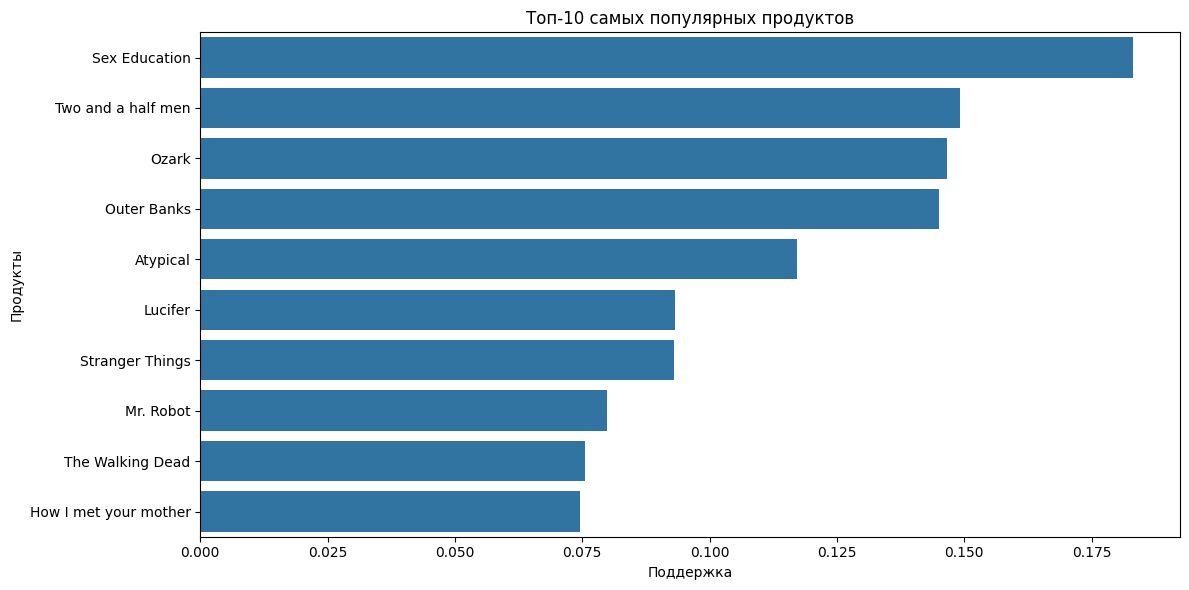

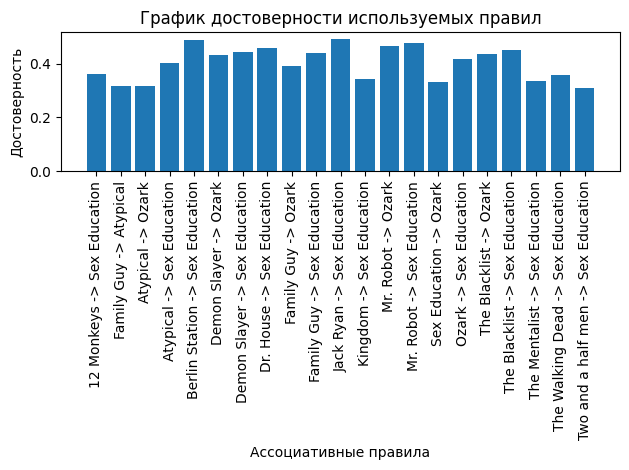

In [4]:
df1 = apriori(data, min_support=0.02, use_colnames = True)
print(df1)
rules = association_rules(df1, metric = "confidence", min_threshold = 0.3)
print(rules)

df1['itemsets'] = df1['itemsets'].apply(lambda x: ', '.join(list(x)))
top_products = df1.sort_values(by='support', ascending=False).head(10)
print(top_products)
plt.figure(figsize=(12, 6))
sns.barplot(x='support', y='itemsets', data=top_products)
plt.title('Топ-10 самых популярных продуктов')
plt.xlabel('Поддержка')
plt.ylabel('Продукты')
plt.tight_layout()
plt.show()

rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))

products_1 = rules["antecedents"].tolist()
products_2 = rules["consequents"].tolist()
confidence = rules["confidence"].tolist()
rules_labels = [f"{product1} -> {product2}" for product1, product2 in zip(products_1, products_2)]
plt.bar(rules_labels, confidence)
plt.xlabel("Ассоциативные правила")
plt.ylabel("Достоверность")
plt.title("График достоверности используемых правил")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Вывод:**

**Популярность отдельных сериалов**

Топ-5 самых частых элементов (по поддержке):

1. Sex Education (18.3% транзакций)
2. Two and a Half Men (14.9%)
3. Ozark (14.7%)
4. Outer Banks (14.5%)
5. Atypical (11.7%)

**Частые наборы TV-шоу:** 82 шт. — включают одиночные товары (12 Monkeys), (Absentia), (Alice in Borderland) и двойные (Sex Education, The Blacklist), (Two and a half men, Stranger Things).

**Ассоциативные правила:** 21 шт. Почти все правила включают Sex Education — это самый популярное TV-шоу.

Lift > 1.8 у всех правил. Можно считать правила с Lift > 2.5 полезными, а остальные правила потенциально тревиальными, потому что некоторые связи могут быть обусловлены общей популярностью, а не содержанием.

Все 21 правило статистически значимы (lift > 1), надёжны (confidence > 0.25) и не случайны (conviction > 1).

Особенно выделяются правила с lift > 2.5:

1. Mr. Robot → Ozark (confidence = 0.466, lift = 3.18)

2. The Blacklist → Ozark (confidence = 0.435, lift = 2.97)

3. Demon Slayer → Ozark (confidence = 0.432, lift = 2.95)

4. Jack Ryan → Sex Education (confidence = 0.492, lift = 2.68)

5. Family Guy → Ozark (confidence = 0.393, lift = 2.68)

6. Berlin Station → Sex Education (confidence = 0.488, lift = 2.66)

7. Dr. House → Sex Education (confidence = 0.459, lift = 2.51)

**Влияния параметров алгоритма на получаемые правила:**
Поддержка 0.02 даёт редкие, но потенциально интересные комбинации. Достоверность 0.3 снижает вероятность малополезных правил. Параметры рекомендуемы при фильтрации lift > 2.5 для отбора наиболее значимых правил.

### Алгоритм FPG

In [5]:
df1 = fpgrowth(data, min_support=0.02, use_colnames = True)
print(df1)
rules = association_rules(df1, metric = "confidence", min_threshold = 0.3)
print(rules)

df1['itemsets'] = df1['itemsets'].apply(lambda x: ', '.join(list(x)))

rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))

     support                       itemsets
0   0.068531                (The Mentalist)
1   0.055940                   (12 Monkeys)
2   0.050263                    (Chernobyl)
3   0.044483                    (Jack Ryan)
4   0.031479                      (Vikings)
..       ...                            ...
77  0.020539          (Ozark, Demon Slayer)
78  0.021158  (Sex Education, Demon Slayer)
79  0.037259             (Ozark, Mr. Robot)
80  0.038084     (Sex Education, Mr. Robot)
81  0.020642          (Mr. Robot, Atypical)

[82 rows x 2 columns]
             antecedents      consequents  antecedent support  \
0        (The Mentalist)  (Sex Education)            0.068531   
1           (12 Monkeys)  (Sex Education)            0.055940   
2            (Jack Ryan)  (Sex Education)            0.044483   
3     (The Walking Dead)  (Sex Education)            0.075446   
4              (Kingdom)  (Sex Education)            0.059346   
5            (Dr. House)  (Sex Education)            0.0584

**Все 21 полученные правила:**
1.  The Mentalist → Sex Education (support = 0.023, confidence = 0.334, lift = 1.825)
2.  12 Monkeys → Sex Education (support = 0.020, confidence = 0.360, lift = 1.964)
3.  Jack Ryan → Sex Education (support = 0.022, confidence = 0.492, lift = 2.685)
4.  The Walking Dead → Sex Education (support = 0.027, confidence = 0.357, lift = 1.949)
5.  Kingdom → Sex Education (support = 0.020, confidence = 0.343, lift = 1.870)
6.  Dr. House → Sex Education (support = 0.027, confidence = 0.459, lift = 2.507)
7.  Atypical → Sex Education (support = 0.047, confidence = 0.403, lift = 2.198)
8.  Atypical → Ozark (support = 0.037, confidence = 0.315, lift = 2.152)
9.  Two and a half men → Sex Education (support = 0.046, confidence = 0.308, lift = 1.684)
10. The Blacklist → Sex Education (support = 0.025, confidence = 0.450, lift = 2.457)
11. The Blacklist → Ozark (support = 0.024, confidence = 0.435, lift = 2.971)
12. Berlin Station → Sex Education (support = 0.023, confidence = 0.488, lift = 2.664)
13. Family Guy → Sex Education (support = 0.028, confidence = 0.439, lift = 2.399)
14. Family Guy → Ozark (support = 0.025, confidence = 0.393, lift = 2.679)
15. Family Guy → Atypical (support = 0.020, confidence = 0.315, lift = 2.689)
16. Sex Education → Ozark (support = 0.061, confidence = 0.332, lift = 2.268)
17. Ozark → Sex Education (support = 0.061, confidence = 0.415, lift = 2.268)
18. Demon Slayer → Ozark (support = 0.021, confidence = 0.432, lift = 2.945)
19. Demon Slayer → Sex Education (support = 0.021, confidence = 0.445, lift = 2.427)
20. Mr. Robot → Ozark (support = 0.037, confidence = 0.466, lift = 3.182)
21. Mr. Robot → Sex Education (support = 0.038, confidence = 0.477, lift = 2.602)

Наиболее значимые правила (lift > 2.5):
1. Mr. Robot → Ozark (lift = 3.18)
2. The Blacklist → Ozark (lift = 2.97)
3. Demon Slayer → Ozark (lift = 2.95)
4. Family Guy → Atypical (lift = 2.69)
5. Jack Ryan → Sex Education (lift = 2.68)
6. Family Guy → Ozark (lift = 2.68)
7. Berlin Station → Sex Education (lift = 2.66)
8. Mr. Robot → Sex Education (lift = 2.60)

### Определение минимальных значений поддержки

In [6]:
min_support_for_k = {}

for support in np.arange(0.05, 0.0, -0.005):
    freq_itemsets = fpgrowth(data, min_support=support, use_colnames=True)
    
    if len(freq_itemsets) == 0:
        continue
    
    freq_itemsets['length'] = freq_itemsets['itemsets'].apply(lambda x: len(x))
    max_len = freq_itemsets['length'].max()
    
    for k in range(1, max_len + 1):
        if k not in min_support_for_k:
            min_support_for_k[k] = support

sorted_k = sorted(min_support_for_k.items())

print("Минимальная поддержка, при которой появляются наборы длины k:")
for k, sup in sorted_k:
    print(f"  k = {k}: min_support = {sup:.3f}")

Минимальная поддержка, при которой появляются наборы длины k:
  k = 1: min_support = 0.050
  k = 2: min_support = 0.050
  k = 3: min_support = 0.015
  k = 4: min_support = 0.005


### Влияние параметров на результат

In [11]:
param_combinations = [
    (0.05, 0.4),
    (0.03, 0.3),
    (0.01, 0.2),
    (0.005, 0.15),

    (0.02, 0.35),
    (0.02, 0.3),
    (0.02, 0.25),

    (0.05, 0.3),
    (0.04, 0.3),
    (0.03, 0.3)
]

results = []

for min_sup, min_conf in param_combinations:
    freq_itemsets = fpgrowth(data, min_support=min_sup, use_colnames=True)
    n_itemsets = len(freq_itemsets)
    
    if n_itemsets > 0:
        rules = association_rules(freq_itemsets, metric="confidence", min_threshold=min_conf)
        n_rules = len(rules)

        avg_conf = rules['confidence'].mean() if n_rules > 0 else 0
        avg_lift = rules['lift'].mean() if n_rules > 0 else 0
    else:
        n_rules, avg_conf, avg_lift = 0, 0, 0
    
    results.append({
        'min_support': min_sup,
        'min_confidence': min_conf,
        'Частые наборы': n_itemsets,
        'Правила': n_rules,
        'Средняя достоверность': round(avg_conf, 3),
        'Средний лифт': round(avg_lift, 3)
    })

results_df = pd.DataFrame(results)
print(results_df)

   min_support  min_confidence  Частые наборы  Правила  Средняя достоверность  \
0        0.050            0.40             19        1                  0.415   
1        0.030            0.30             43        7                  0.388   
2        0.010            0.20            225      169                  0.321   
3        0.005            0.15            663      752                  0.307   
4        0.020            0.35             82       15                  0.434   
5        0.020            0.30             82       21                  0.403   
6        0.020            0.25             82       30                  0.359   
7        0.050            0.30             19        2                  0.374   
8        0.040            0.30             29        4                  0.365   
9        0.030            0.30             43        7                  0.388   

   Средний лифт  
0         2.268  
1         2.336  
2         2.367  
3         2.693  
4         2.527  


**Вывод:** 

1. Равномерное снижение обоих параметров (строки 0-3)

При снижении порогов число правил резко возрастает (в 752 раза!). Средняя достоверность снижается — правила становятся менее надёжными. Средний лифт растёт, особенно при support=0.005, значит, появляются редкие, но сильно связанные пары. Однако 752 правила — это слишком много для интерпретации, большинство из них малозначимы на практике. Такой подход подходит для разведочного анализа, но не для финальной модели.

2. Фиксированный min_support = 0.02, меняется min_confidence (строки 4–6)

При снижении min_confidence: число правил увеличивается, но средняя достоверность и лифт падают.

При min_confidence = 0.35 получаем мало, но очень качественных правил (высокая надёжность и сильная связь).

При min_confidence = 0.25 — больше правил, но часть из них может быть слабо обоснованной.

Для практического применения оптимален порог 0.30–0.35.

3. Фиксированный min_confidence = 0.30, меняется min_support (строки 7–9)

При снижении min_support число правил растёт, что ожидаемо. Наилучший баланс при min_support = 0.03: достаточно правил (7), высокая достоверность (0.388), максимальный лифт (2.336). При min_support = 0.04 лифт падает до 2.104 → появляются менее значимые связи. Для фильтрации по поддержке лучше выбрать 0.03.





### Граф

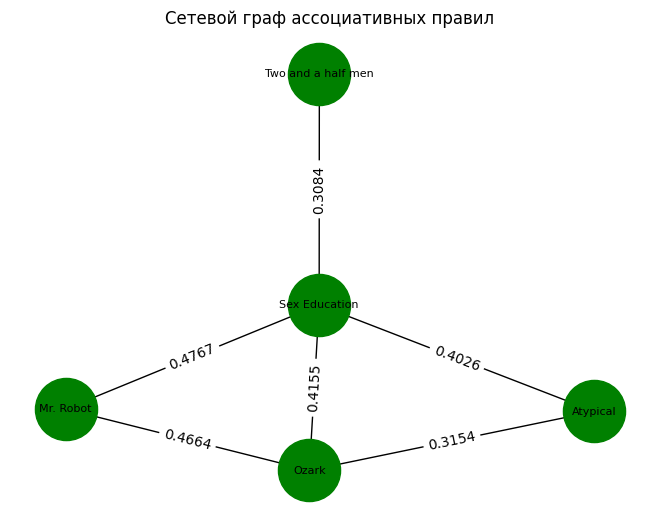

In [27]:
def itemset_to_str(itemset):
    return ', '.join(sorted(itemset))

G = nx.Graph()

for _, row in rules.iterrows():
    ant = itemset_to_str(row['antecedents'])
    cons = itemset_to_str(row['consequents'])
    G.add_node(ant)
    G.add_node(cons)
    G.add_edge(ant, cons, weight=row['confidence'])
    
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='green', font_size=8)
edge_labels = {k: f"{v:.4f}" for k, v in nx.get_edge_attributes(G, 'weight').items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title('Сетевой граф ассоциативных правил')
plt.subplots_adjust()
plt.show()

**Вывод:** 

**Структура графа**

Граф представляет собой неориентированный граф, где:

Узлы (вершины) — это отдельные TV-шоу: Two and a half men, Sex Education, Mr. Robot, Ozark, Atypical.

Рёбра — связи между шоу, вес которых равен достоверности (confidence) правила.

**Анализ графа**

Все рёбра имеют веса в диапазоне 0.3084 – 0.4767, что означает:

Достоверность всех связей выше порога 0.3, установленного в задании.

Наиболее сильная связь: Mr. Robot — Sex Education (confidence = 0.4767).

Наименее сильная связь: Two and a half men — Sex Education (confidence = 0.3084).

**Центральные узлы**

Самый "центральный" узел — Sex Education:

Он связан со всеми остальными четырьмя шоу.

Сумма весов его рёбер: 0.4767 + 0.4155 + 0.4026 + 0.3084 = 1.6032

Это указывает на то, что Sex Education — ключевой элемент в этой сети, часто встречающийся в парах с другими популярными сериалами.

**Интерпретация связей**

Sex Education — Mr. Robot (0.4767) — самая сильная связь. Возможно, оба шоу привлекают молодую аудиторию или имеют схожий стиль (драма/комедия с элементами драмы).

Sex Education — Ozark (0.4155) — интересная связь: подростковая комедия и криминальный триллер. Может быть объяснена общей платформой (Netflix) или пересечением аудитории.

Ozark — Mr. Robot (0.4664) — логичная связь: оба — серьёзные драмы/триллеры.

Two and a half men — Sex Education (0.3084) — слабая, но значимая связь. Возможно, зрители, смотрящие комедии, иногда переходят к более современным драмам.

### Диаграмма рассеивания

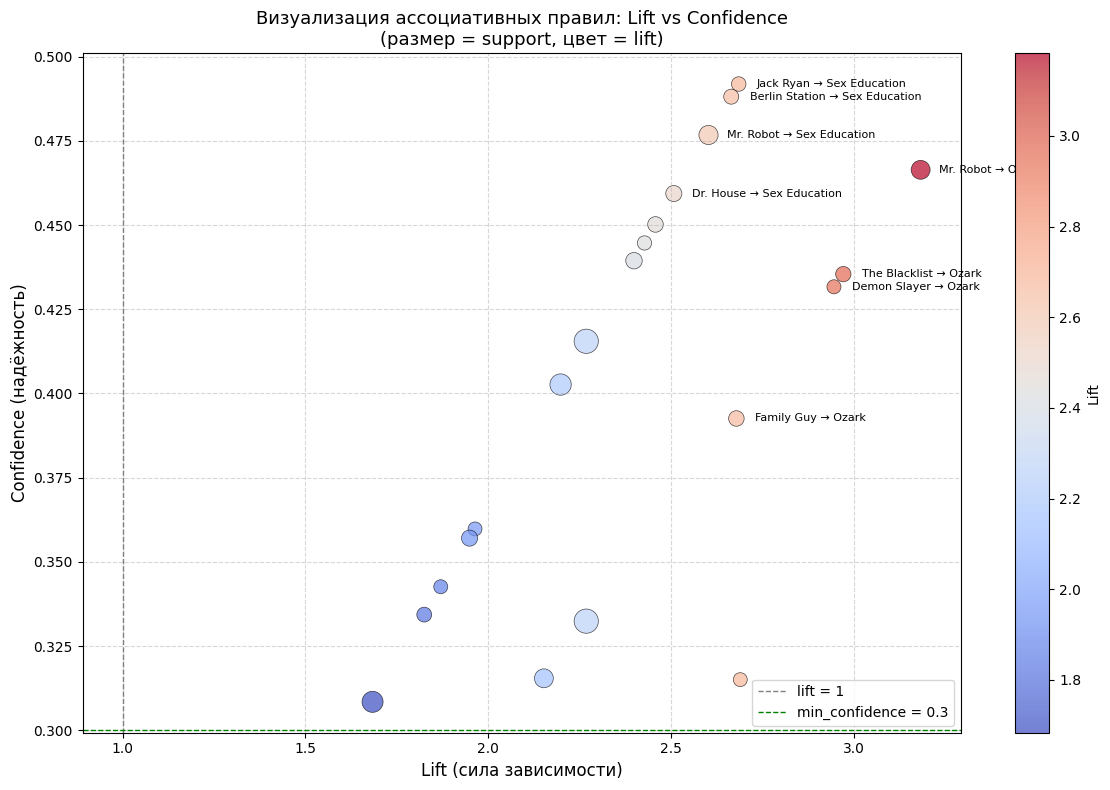

In [41]:
df1 = fpgrowth(data, min_support=0.02, use_colnames=True)
rules = association_rules(df1, metric="confidence", min_threshold=0.3)

rules_vis = rules.copy()
rules_vis['antecedents_str'] = rules_vis['antecedents'].apply(itemset_to_str)
rules_vis['consequents_str'] = rules_vis['consequents'].apply(itemset_to_str)
rules_vis['rule_label'] = rules_vis['antecedents_str'] + ' → ' + rules_vis['consequents_str']

plt.figure(figsize=(12, 8))

scatter = plt.scatter(
    rules_vis['lift'],
    rules_vis['confidence'],
    s=rules_vis['support'] * 5000,
    c=rules_vis['lift'],
    cmap='coolwarm',
    alpha=0.7,
    edgecolors='k',
    linewidth=0.5
)

top_rules = rules_vis[(rules_vis['lift'] > 2.5) & (rules_vis['confidence'] > 0.35)]
for _, row in top_rules.iterrows():
    plt.text(
        row['lift'] + 0.05,
        row['confidence'],
        row['rule_label'],
        fontsize=8,
        ha='left',
        va='center'
    )

plt.xlabel('Lift (сила зависимости)', fontsize=12)
plt.ylabel('Confidence (надёжность)', fontsize=12)
plt.title('Визуализация ассоциативных правил: Lift vs Confidence\n(размер = support, цвет = lift)', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.5)

plt.axvline(x=1.0, color='gray', linestyle='--', linewidth=1, label='lift = 1')
plt.axhline(y=0.3, color='green', linestyle='--', linewidth=1, label='min_confidence = 0.3')

plt.colorbar(scatter, label='Lift')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

**Lift** → отображается по оси X

Показывает силу зависимости.

Чем больше значение (правее точка), тем связь менее случайна и более содержательна.

**Confidence** → отображается по оси Y

Показывает надёжность правила (насколько часто оно выполняется).

Чем выше точка, тем правило более предсказуемо.

**Support** → отображается через размер точки

Показывает популярность правила (насколько часто эта комбинация встречается в данных).

Чем крупнее точка — тем правило релевантнее для большей части пользователей.

**Вывод:**
Все точки находятся выше горизонтальной линии min_confidence = 0.3, что означает, что все правила соответствуют заданному порогу достоверности.
Большинство точек сосредоточено в области lift от 1.6 до 2.8 и confidence от 0.3 до 0.49, что указывает на умеренно сильные и надёжные ассоциации.

Самое "сильное" правило: Mr. Robot → Ozark (красная точка, lift ≈ 3.18, confidence ≈ 0.47). Это лучшее правило по всем трём метрикам: высокий лифт (не случайная связь), высокая достоверность (надёжно) и большой размер (популярно).

## 4. Заключение

В ходе выполнения лабораторной работы были успешно исследованы методы анализа ассоциативных правил на реальном транзакционном датасете, содержащем информацию о совместно выбранных TV-шоу. Были реализованы и сравнены два ключевых алгоритма — Apriori и FPG — с использованием библиотеки mlxtend.

В результате анализа:

Получены частые наборы и ассоциативные правила при различных порогах поддержки (min_support) и достоверности (min_confidence).
Выявлены содержательные связи между сериалами, такие как Mr. Robot → Ozark (lift = 3.18) и Jack Ryan → Sex Education (lift = 2.68), которые отражают не случайные совпадения, а устойчивые предпочтения аудитории.
Показано, что параметры алгоритма напрямую влияют на количество и качество правил. Слишком строгие пороги приводят к потере осмысленных связей, а слишком мягкие — к избыточному шуму.
Проведена оценка метрик. Все сгенерированные правила имеют lift > 1.6, confidence > 0.25 и ненулевую поддержку, что подтверждает их статистическую значимость.
Реализованы три способа визуализации.
Гистограмма длин транзакций — для понимания структуры данных,
Сетевой граф — для отображения связей между шоу,
Оригинальный scatter plot — интегрирующий три метрики (support, confidence, lift) в одном графике, что позволило наглядно выделить наиболее ценные правила.

## 5. Список литературы

1. Agrawal, R., Imieliński, T., & Swami, A. (1993). Mining Association Rules Between Sets of Items in Large Databases. Proceedings of the 1993 ACM SIGMOD International Conference on Management of Data (SIGMOD '93), 207–216. — URL: https://doi.org/10.1145/170036.170072 (дата обращения: 27.11.2025).
2. Han, J., Pei, J., & Yin, Y. (2000). Mining Frequent Patterns without Candidate Generation. Proceedings of the 2000 ACM SIGMOD International Conference on Management of Data (SIGMOD '00), 1–12. — URL: https://doi.org/10.1145/342009.335372 (дата обращения: 27.11.2025).
3. mlxtend Documentation. (n.d.). Frequent Pattern Mining. — URL: https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/ (дата обращения: 27.11.2025).
4. NetworkX Documentation. (n.d.). NetworkX: Network Analysis in Python. — URL: https://networkx.org/documentation/stable/ (дата обращения: 27.11.2025).
5. Kaggle: OTT TVshows Dataset. — URL: https://www.kaggle.com/datasets/cyberphile/ott-tvshows (дата обращения: 27.11.2025).